## Neural Part Of Speech Tagging

We're now going to solve the same problem of POS tagging with neural networks.
<img src=https://i.stack.imgur.com/6pdIT.png width=320>

From deep learning perspective, this is a task of predicting a sequence of outputs aligned to a sequence of inputs. There are several problems that match this formulation:
* Part Of Speech Tagging -  an auxuliary task for many NLP problems
* Named Entity Recognition - for chat bots and web crawlers
* Protein structure prediction - for bioinformatics

In [1]:
import nltk
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa

In [258]:
# сохраним полезную функцию отрисовки графиков в самом начале, чтобы не искать в блокноте
def make_plots(model, name='Test', save=False):
    fig = plt.figure(figsize=(15,5))
    fig.suptitle(name, fontsize=20)

    fig.add_subplot(121)
    plt.plot(model.history.history['loss'],'b--',label='train')
    plt.plot(model.history.history['val_loss'],'g-',label='validation')
    plt.legend(loc='best')
    plt.ylabel('loss')
    x_right_limit = len(model.history.history['loss'])
    tick = int((x_right_limit+1)/10)
    if tick<1: tick=1
    plt.xticks(range(0,x_right_limit+1,tick))
    plt.grid()
    plt.xlabel('epochs')
    plt.title('Loss_vs_epoch');

    fig.add_subplot(122)
    plt.plot(model.history.history['categorical_accuracy'],'b--',label='train')
    plt.plot(model.history.history['val_categorical_accuracy'],'g-',label='validation')
    plt.legend(loc='best')
    plt.ylabel('accuracy')
    plt.xticks(range(0,x_right_limit+1,tick))
    plt.grid()
    plt.xlabel('epochs')
    plt.title('Accuracy_vs_epoch');
    
    if save: fig.savefig(name)

In [3]:
nltk.download('brown')
nltk.download('universal_tagset')
data = nltk.corpus.brown.tagged_sents(tagset='universal')
all_tags = ['#EOS#','#UNK#','ADV', 'NOUN', 'ADP', 'PRON', 'DET', '.', 'PRT', 'VERB', 'X', 'NUM', 'CONJ', 'ADJ']
empty = []
data = np.array([ [(word.lower(),tag) if tag in all_tags else empty.append(tag) for word,tag in sentence] for sentence in data ])

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Sony\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Sony\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
C:\Users\Sony\AppData\Local\Temp/ipykernel_7372/3592620917.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array([ [(word.lower(),tag) if tag in all_tags else empty.append(tag) for word,tag in sentence] for sentence in data ])


In [4]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data,test_size=0.25,random_state=42)

In [5]:
from IPython.display import HTML,display

In [6]:
from IPython.display import HTML, display
def draw(sentence):
    words,tags = zip(*sentence)
    display(HTML('<table><tr>{tags}</tr>{words}<tr></table>'.format(
                words = '<td>{}</td>'.format('</td><td>'.join(words)),
                tags = '<td>{}</td>'.format('</td><td>'.join(tags)))))
    
    
draw(data[11])
draw(data[10])
draw(data[7])

NOUN,ADP,NOUN,NOUN,NOUN,NOUN,VERB,ADV,VERB,ADP,DET,ADJ,NOUN,.,implementation,of,georgia's,automobile,title,law,was,also,recommended,by,the,outgoing,jury,.


PRON,VERB,ADP,DET,NOUN,.,VERB,NOUN,PRT,VERB,.,DET,NOUN,.,it,urged,that,the,city,``,take,steps,to,remedy,'',this,problem,.


NOUN,VERB,merger,proposed


In [7]:
draw(data[1])

DET,NOUN,ADV,VERB,ADP,NOUN,NOUN,ADP,DET,NOUN,ADJ,NOUN,.,DET,VERB,ADJ,NOUN,ADP,DET,NOUN,.,.,VERB,DET,NOUN,CONJ,NOUN,ADP,DET,NOUN,ADP,NOUN,.,ADP,DET,NOUN,ADP,DET,DET,NOUN,VERB,VERB,.,the,jury,further,said,in,term-end,presentments,that,the,city,executive,committee,",",which,had,over-all,charge,of,the,election,",",``,deserves,the,praise,and,thanks,of,the,city,of,atlanta,'',for,the,manner,in,which,the,election,was,conducted,.


Сделаем лучше представление:

In [7]:
def draw_better(sentence,fill='NaN'):
    a={}
    for i,j in sentence:
        if j in all_tags:
            if j not in a.keys():
                a[j]=[]

            a[j].append(i)
    return pd.DataFrame.from_dict(a,orient='index').T.fillna(fill)
    

In [8]:
draw_better(data[1],'-')

,DET,NOUN,ADV,VERB,ADP,ADJ,.,CONJ
0,the,jury,further,said,in,executive,",",and
1,the,term-end,-,had,that,over-all,",",-
2,which,presentments,-,deserves,of,-,``,-
3,the,city,-,was,of,-,'',-
4,the,committee,-,conducted,of,-,.,-
5,the,charge,-,-,for,-,-,-
6,the,election,-,-,in,-,-,-
7,which,praise,-,-,-,-,-,-
8,the,thanks,-,-,-,-,-,-
9,-,city,-,-,-,-,-,-


### Building vocabularies

Just like before, we have to build a mapping from tokens to integer ids. This time around, our model operates on a word level, processing one word per RNN step. This means we'll have to deal with far larger vocabulary.

Luckily for us, we only receive those words as input i.e. we don't have to predict them. This means we can have a large vocabulary for free by using word embeddings.

Make our counter

In [9]:
#make counter
def make_tokens_dictionary(word, tokens_dictionary ={}):
    if word not in tokens_dictionary.keys():
        tokens_dictionary[word] = 1
    else:
        tokens_dictionary[word] +=1

    return tokens_dictionary

In [10]:
#count
tokens_dictionary={}

for sent in data:
    word,tag = zip(*sent)
    for i in word:
        make_tokens_dictionary(word=i, tokens_dictionary=tokens_dictionary)

assert len(tokens_dictionary) > 40000
print('Done!')

Done!


In [11]:
#sort
tokens_dictionary = dict(sorted(tokens_dictionary.items(), key = lambda x: x[1],reverse=True))

assert next(iter(tokens_dictionary.items()) )[1] > 60000
print('Done!')

Done!


Print top5 and tail5 words

In [12]:
print('\n'.join ( map(str,list(tokens_dictionary.items())[:5] ) ))
print('\n'.join ( map(str,list(tokens_dictionary.items())[-5:] ) ))

('the', 69971)
(',', 58334)
('.', 49346)
('of', 36412)
('and', 28853)
('aviary', 1)
('olive-flushed', 1)
('coral-colored', 1)
('boucle', 1)
('stupefying', 1)


In [13]:
all_words = ['#EOS#','#UNK#'] + list(tokens_dictionary.keys())[:10000]

In [14]:
a = sum(list(tokens_dictionary.values())[:10000])*1./sum(tokens_dictionary.values())
print("Coverage = %.5f"%a)

Coverage = 0.92876


In [15]:
word_to_id = {word:i for i,word in enumerate(all_words)}
tag_to_id = {tag:i for i,tag in enumerate(all_tags)}

Finished

convert words and tags into fixed-size matrix

In [ ]:
def to_matrix(lines, token_to_id, max_len=None, pad=0, dtype='int32', time_major=False):
    """Converts a list of names into rnn-digestable matrix with paddings added after the end"""
    
    max_len = max_len or max(map(len,lines))
    matrix = np.empty([len(lines), max_len],dtype)
    matrix.fill(pad)

    for i in range(len(lines)):
        line_ix = list(map(token_to_id.__getitem__,lines[i]))[:max_len]
        matrix[i,:len(line_ix)] = line_ix

    return matrix.T if time_major else matrix



In [ ]:
batch_words, batch_tags = zip(*[zip(*sentence) for sentence in data[-3:]])

print("Word ids:")
print(to_matrix(batch_words, word_to_id))
print("Tag ids:")
print(to_matrix(batch_tags, tag_to_id))

### Build model

Unlike our previous lab, this time we'll focus on a high-level keras interface to recurrent neural networks. It is as simple as you can get with RNN, allbeit somewhat constraining for complex tasks like seq2seq.

By default, all keras RNNs apply to a whole sequence of inputs and produce a sequence of hidden states `(return_sequences=True` or just the last hidden state `(return_sequences=False)`. All the recurrence is happening under the hood.

At the top of our model we need to apply a Dense layer to each time-step independently. As of now, by default keras.layers.Dense would apply once to all time-steps concatenated. We use __keras.layers.TimeDistributed__ to modify Dense layer so that it would apply across both batch and time axes.

In [16]:
import keras
import keras.layers as L

In [151]:
input_layer = keras.layers.Input(shape=[None],batch_size=12,dtype=np.int16 )

In [152]:
words_vocabulary_length = len(word_to_id)

embedding_layer = keras.layers.Embedding(input_dim=words_vocabulary_length, 
                                        output_dim=100,
                                        input_length=12)(input_layer)

In [153]:
rnn_hidden_state = len(tag_to_id)

RNN_layer = keras.layers.SimpleRNN(units = rnn_hidden_state,
                                  activation = 'tanh',
                                  return_sequences=True,
                                  stateful=True)(embedding_layer)

In [156]:
Dense_layer = keras.layers.Dense(len(tag_to_id),activation=keras.activations.softmax)
Time_Distibuted_layer = keras.layers.TimeDistributed(Dense_layer)(RNN_layer)

In [157]:
model = keras.models.Model(inputs = input_layer, outputs = Time_Distibuted_layer  )

In [159]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(12, None)]              0         
_________________________________________________________________
embedding (Embedding)        (12, None, 100)           1000200   
_________________________________________________________________
simple_rnn (SimpleRNN)       (12, None, 14)            1610      
_________________________________________________________________
time_distributed (TimeDistri (12, None, 14)            210       
Total params: 1,002,020
Trainable params: 1,002,020
Non-trainable params: 0
_________________________________________________________________


In [161]:
# here I will make the batch_preparator function:

In [ ]:
# we will feed to model the sequence by sequence 
# as we have the "Many to many" (return_sequence=True), 
# we have to prepare the input sequence in fixed size --> we will make function: "make_matrix_for_RNN"
# an empty space will fill with 'EOS',
# an unknown word will fill with 'UNK'

In [430]:
pad_id,unknown_id = map(word_to_id.get, ['#EOS#','#UNK#'] )

def make_matrix_for_RNN(sequences,max_len=None):
    #sequences = data[:3]
    # узнаем макс длину матрицы
    if max_len is None:
        max_len = min(max(map(len, sequences)), np.inf)
    else: 
        max_len = max_len #min( max(map(len,sequences)),max_len ,np.inf)
        
    # создадим матрицу размера No.sequences, max_len, fill PAD
    matrix_words = np.full(shape=(len(sequences),max_len ),fill_value=pad_id, dtype=int)
    matrix_tags = np.full(shape=(len(sequences),max_len ),fill_value=pad_id, dtype=int)
    
    # пробежимся по матрице и каждый ряд заполняем id слова или (если такое слово отсутствует ставим UNK_id)
    for i,line in enumerate(sequences):
        word,tag = zip(*line)
        a = [word_to_id.get(i,unknown_id) for i in word ]
        b = [tag_to_id.get(i,unknown_id) for i in tag ]
        
        matrix_words[i,:len(a)] = a
        matrix_tags[i,:len(b)] = b
    return matrix_words,matrix_tags

In [56]:
#Check function
make_matrix_for_RNN(data[1:3])

(array([[   2, 1635,  440,   63,    9,    1,    1,   10,    2,  239, 2029,
          603,    3,   38,   28, 3108,  862,    5,    2, 1402,    3,   15,
         5686,    2, 5435,    6, 2955,    5,    2,  239,    5, 3109,   16,
           14,    2,  851,    9,   38,    2, 1402,   12, 2030,    4],
        [   2,    1, 1372, 1635,   28,   51, 1957,   25, 5434, 2401,  417,
         1403,    1,    1,    7, 7450, 1285,    5,  256,   15, 9200,   16,
            9,    2,    1, 1121,   38,   12, 1596,   25,    1,    1, 4808,
         1435,    4,    0,    0,    0,    0,    0,    0,    0,    0]]),
 array([[ 6,  3,  2,  9,  4,  3,  3,  4,  6,  3, 13,  3,  7,  6,  9, 13,
          3,  4,  6,  3,  7,  7,  9,  6,  3, 12,  3,  4,  6,  3,  4,  3,
          7,  4,  6,  3,  4,  6,  6,  3,  9,  9,  7],
        [ 6,  3,  3,  3,  9,  9,  9,  4,  3, 13,  3,  3,  3,  3,  8,  9,
          3,  4, 13,  7,  3,  7,  4,  6, 13,  3,  6,  9,  9,  4,  3,  3,
          3,  3,  7,  0,  0,  0,  0,  0,  0,  0,  0]]))

In [ ]:
#batch_preparator function

In [428]:
from keras.utils.np_utils import to_categorical

def iterate_minibatches(source,batch_size = 12,shuffle=True, **kwargs):
    while True:
        data_indexes = np.arange(len(source))
        if shuffle:
            #shuffle
            data_indexes_shuffled = np.random.permutation(data_indexes)
            batch_indexes = data_indexes_shuffled[:batch_size]
        else:
            # NO shuffle
            batch_indexes = data_indexes[-batch_size:] #no shuffle is useless

        #generating X and y 
        batch,target = make_matrix_for_RNN(source[batch_indexes], **kwargs)

        target = to_categorical(target, len(all_tags) ).reshape(target.shape+(-1,))

        yield batch,target

__Training:__ in this case we don't want to prepare the whole training dataset in advance. The main cause is that the length of every batch depends on the maximum sentence length within the batch. This leaves us two options: use custom training code as in previous seminar or use generators.

Keras models have a __`model.fit_generator`__ method that accepts a python generator yielding one batch at a time. But first we need to implement such generator:

In [301]:
model.compile(optimizer='adam', 
              loss=keras.losses.categorical_crossentropy,
              metrics=keras.metrics.categorical_accuracy)

In [300]:
callbacks = [keras.callbacks.ModelCheckpoint(
        filepath='./saved_models/best_model.{epoch:03d}-loss_{val_loss:.2f}.h5',
        save_best_only=True,
        save_weights_only=True,
        monitor='val_loss',
        mode='min'),
        
        keras.callbacks.TensorBoard(
        log_dir ='../TensorBoard_logs/' ,
        histogram_freq = 1,
        write_graph = False,
        write_images = False,
        write_steps_per_second = False,
        update_freq = 'epoch',
        profile_batch = 2,
        embeddings_freq = 1
        )]

In [25]:
#make validation split
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(train_data,test_size=0.15,random_state=255)

In [324]:
batch_size = 12
epochs = 5
step_per_epoch = (len(X_train)+1) // (batch_size+1)
validation_steps = (len(X_val)+1) // (batch_size+1)

model.fit(iterate_minibatches(X_train, batch_size = batch_size ,shuffle=True),
         epochs = epochs, steps_per_epoch = step_per_epoch,
         callbacks = callbacks,
         validation_data = iterate_minibatches(X_val, batch_size = batch_size ,shuffle=True),
         validation_steps = validation_steps, verbose=1 )

Epoch 1/5
2811/2811 [==============================] - 68s 24ms/step - loss: 0.0689 - categorical_accuracy: 0.9768 - val_loss: 0.0706 - val_categorical_accuracy: 0.9765
Epoch 2/5
2811/2811 [==============================] - 69s 25ms/step - loss: 0.0644 - categorical_accuracy: 0.9783 - val_loss: 0.0694 - val_categorical_accuracy: 0.9768
Epoch 3/5
2811/2811 [==============================] - 67s 24ms/step - loss: 0.0615 - categorical_accuracy: 0.9793 - val_loss: 0.0712 - val_categorical_accuracy: 0.9763
Epoch 4/5
2811/2811 [==============================] - 67s 24ms/step - loss: 0.0593 - categorical_accuracy: 0.9800 - val_loss: 0.0740 - val_categorical_accuracy: 0.9757
Epoch 5/5
2811/2811 [==============================] - 67s 24ms/step - loss: 0.0579 - categorical_accuracy: 0.9805 - val_loss: 0.0700 - val_categorical_accuracy: 0.9767


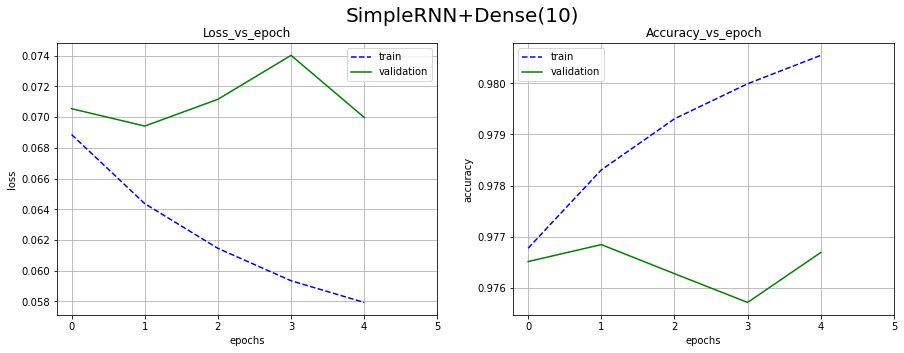

In [336]:
make_plots(model,name='SimpleRNN+Dense(10)',save=True)

__Callbacks:__ Another thing we need is to measure model performance. The tricky part is not to count accuracy after sentence ends (on padding) and making sure we count all the validation data exactly once.

While it isn't impossible to persuade Keras to do all of that, we may as well write our own callback that does that.
Keras callbacks allow you to write a custom code to be ran once every epoch or every minibatch. We'll define one via LambdaCallback

In [270]:
from sklearn.metrics import accuracy_score

def calc_test_accuracy(model):
    acc =0
    batches = len(test_data)//12
    
    for i in range(0,batches,1):
        X,y = make_matrix_for_RNN(test_data[i*12:i*12+12])
        y_predicted = model.predict(X)
        y_predicted = np.argmax(y_predicted,axis=-1)
        acc += accuracy_score(np.ravel(y),np.ravel(y_predicted))
    
    return acc/ batches

Measure final accuracy on the whole test set.

In [433]:
acc = calc_test_accuracy(model)
print("Final accuracy: %.5f"%acc)

assert acc>0.94, "Keras has gone on a rampage again, please contact course staff."

Final accuracy: 0.97447


### Going bidirectional

Since we're analyzing a full sequence, it's legal for us to look into future data.

A simple way to achieve that is to go both directions at once, making a __bidirectional RNN__.

In Keras you can achieve that both manually (using two LSTMs and Concatenate) and by using __`keras.layers.Bidirectional`__. 

This one works just as `TimeDistributed` we saw before: you wrap it around a recurrent layer (SimpleRNN now and LSTM/GRU later) and it actually creates two layers under the hood.

Your first task is to use such a layer our POS-tagger.

In [449]:
#Define a model that utilizes bidirectional SimpleRNN
model_2 = keras.models.Sequential()

#input
model_2.add(keras.layers.Input(shape=[None],batch_size=12,dtype=np.int16 ))

#make Embedding
words_vocabulary_length = len(word_to_id)
model_2.add(keras.layers.Embedding(input_dim=words_vocabulary_length, 
          output_dim=100, input_length=12 ))

#make two-directional RNN
rnn_hidden_state = len(tag_to_id)
RNN_layer = keras.layers.SimpleRNN(units = rnn_hidden_state,
          activation = 'tanh',
          return_sequences=True,
          stateful=True) 
model_2.add( keras.layers.Bidirectional(RNN_layer) )
            
#make TimeDistibuted Dense
Dense_layer = keras.layers.Dense(len(tag_to_id),activation=keras.activations.softmax)
model_2.add( keras.layers.TimeDistributed(Dense_layer))        
            

In [450]:
model_2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (12, None, 100)           1000200   
_________________________________________________________________
bidirectional_4 (Bidirection (12, None, 28)            3220      
_________________________________________________________________
time_distributed_2 (TimeDist (12, None, 14)            406       
Total params: 1,003,826
Trainable params: 1,003,826
Non-trainable params: 0
_________________________________________________________________


In [451]:
model_2.compile(optimizer='adam', 
              loss=keras.losses.categorical_crossentropy,
              metrics=keras.metrics.categorical_accuracy)

In [454]:
callbacks = [keras.callbacks.ModelCheckpoint(
        filepath='./saved_models/model_2.{epoch:03d}-loss_{val_loss:.2f}.h5',
        save_best_only=True,
        save_weights_only=True,
        monitor='val_loss',
        mode='min'),
        
        keras.callbacks.TensorBoard(
        log_dir ='../TensorBoard_logs/model_2/' ,
        histogram_freq = 1,
        write_graph = False,
        write_images = False,
        write_steps_per_second = False,
        update_freq = 'epoch',
        profile_batch = 2,
        embeddings_freq = 1
        )]

In [323]:
#make validation split
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(train_data,test_size=0.15,random_state=255)

In [455]:
batch_size = 12
epochs = 5
step_per_epoch = (len(X_train)+1) // (batch_size+1)
validation_steps = (len(X_val)+1) // (batch_size+1)

model_2.fit(iterate_minibatches(X_train, batch_size = batch_size ,shuffle=True),
         epochs = epochs, steps_per_epoch = step_per_epoch,
         callbacks = callbacks,
         validation_data = iterate_minibatches(X_val, batch_size = batch_size ,shuffle=True),
         validation_steps = validation_steps, verbose=1 )

Epoch 1/5
2811/2811 [==============================] - 86s 30ms/step - loss: 0.1667 - categorical_accuracy: 0.9556 - val_loss: 0.0612 - val_categorical_accuracy: 0.9808
Epoch 2/5
2811/2811 [==============================] - 82s 29ms/step - loss: 0.0490 - categorical_accuracy: 0.9845 - val_loss: 0.0540 - val_categorical_accuracy: 0.9828
Epoch 3/5
2811/2811 [==============================] - 81s 29ms/step - loss: 0.0400 - categorical_accuracy: 0.9873 - val_loss: 0.0538 - val_categorical_accuracy: 0.9833
Epoch 4/5
2811/2811 [==============================] - 82s 29ms/step - loss: 0.0345 - categorical_accuracy: 0.9892 - val_loss: 0.0559 - val_categorical_accuracy: 0.9830
Epoch 5/5
2811/2811 [==============================] - 83s 29ms/step - loss: 0.0320 - categorical_accuracy: 0.9901 - val_loss: 0.0555 - val_categorical_accuracy: 0.9833


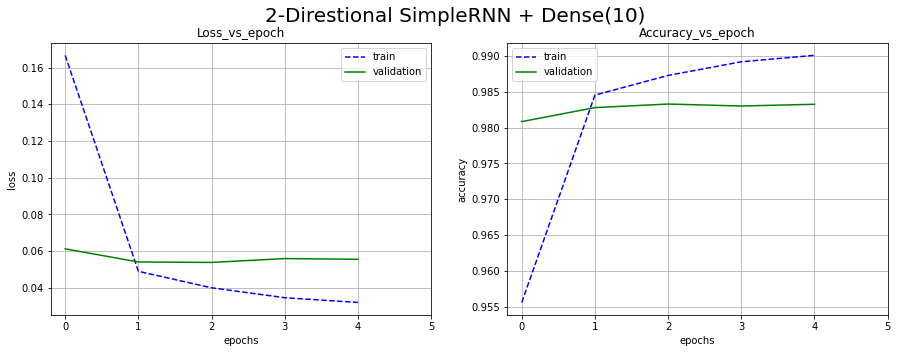

In [456]:
make_plots(model_2,name='2-Direstional SimpleRNN + Dense(10)',save=True)

__Callbacks:__ Another thing we need is to measure model performance. The tricky part is not to count accuracy after sentence ends (on padding) and making sure we count all the validation data exactly once.

While it isn't impossible to persuade Keras to do all of that, we may as well write our own callback that does that.
Keras callbacks allow you to write a custom code to be ran once every epoch or every minibatch. We'll define one via LambdaCallback

In [426]:
from sklearn.metrics import accuracy_score

def calc_test_accuracy(model):
    acc =0
    batches = len(test_data)//12
    
    for i in range(0,batches,1):
        X,y = make_matrix_for_RNN(test_data[i*12:i*12+12])
        y_predicted = model.predict(X)
        y_predicted = np.argmax(y_predicted,axis=-1)
        acc += accuracy_score(np.ravel(y),np.ravel(y_predicted))
    
    return acc/ batches

Measure final accuracy on the whole test set.

In [459]:
acc = calc_test_accuracy(model_2)
print("Final accuracy: %.5f"%acc)

assert acc>0.94, "Bidirectional RNNs are better than this!"
print("Well done!")

Final accuracy: 0.98200
Well done!


Task I: Structured loss functions (more bonus points)

Since we're tagging the whole sequence at once, we might as well train our network to do so. Remember linear CRF from the lecture? You can also use it as a loss function for your RNN


  * There's more than one way to do so, but we'd recommend starting with [Conditional Random Fields](http://blog.echen.me/2012/01/03/introduction-to-conditional-random-fields/)
  * You can plug CRF as a loss function and still train by backprop. There's even some neat tensorflow [implementation](https://www.tensorflow.org/addons/api_docs/python/tfa/layers/CRF) for you.
  * Alternatively, you can condition your model on previous tags (make it autoregressive) and perform __beam search__ over that model.

### Model with the last CRF layer
Embedding -> 2-directional SimpleRNN -> CRF

In [41]:
#Define a model that utilizes Embedding -> 2-directional SimpleRNN -> CRF 

#input
input_layer = keras.layers.Input(shape=[None],batch_size=12,dtype=np.int32 )

#make Embedding
words_vocabulary_length = len(word_to_id)
embedding_layer = keras.layers.Embedding(input_dim=words_vocabulary_length, 
          output_dim=100, input_length=12 )(input_layer)

#make two-directional RNN
rnn_hidden_state = len(tag_to_id)
RNN_layer = keras.layers.SimpleRNN(units = rnn_hidden_state,
          activation = 'tanh',
          return_sequences=True,
          stateful=True) 
two_dir_RNN_layer = keras.layers.Bidirectional(RNN_layer)(embedding_layer)
            
#make CRF
#слой CRF будет иметь количество сущностей = количеству тэгов(crf_entity)
crf_entity = len(tag_to_id)
CRF_layer = tfa.layers.CRF(units = crf_entity)(inputs=two_dir_RNN_layer )   
#result = CRF_layer[0]

model_3 = keras.models.Model(inputs = input_layer, outputs = CRF_layer  )

In [42]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(12, None)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (12, None, 100)           1000200   
_________________________________________________________________
bidirectional_2 (Bidirection (12, None, 28)            3220      
_________________________________________________________________
crf_2 (CRF)                  [(12, None), (12, None, 1 630       
Total params: 1,004,050
Trainable params: 1,004,050
Non-trainable params: 0
_________________________________________________________________


In [43]:
model_3.compile(optimizer='adam', #loss=keras.losses.sparse_categorical_crossentropy ,
              metrics=keras.metrics.sparse_categorical_accuracy)

In [20]:
callbacks = [keras.callbacks.ModelCheckpoint(
        filepath='./saved_models/model_3.{epoch:03d}-loss_{val_loss:.2f}.h5',
        save_best_only=True,
        save_weights_only=True,
        monitor='val_loss',
        mode='min'),
        
        keras.callbacks.TensorBoard(
        log_dir ='../TensorBoard_logs/model_3/' ,
        histogram_freq = 1,
        write_graph = False,
        write_images = False,
        write_steps_per_second = False,
        update_freq = 'epoch',
        profile_batch = 2,
        embeddings_freq = 1
        )]

In [21]:
#make validation split
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(train_data,test_size=0.15,random_state=255)

In [22]:
#from keras.utils.np_utils import to_categorical

def iterate_minibatches_for_CRF(source,batch_size = 12,shuffle=True, **kwargs):
    while True:
        data_indexes = np.arange(len(source))
        if shuffle:
            #shuffle
            data_indexes_shuffled = np.random.permutation(data_indexes)
            batch_indexes = data_indexes_shuffled[:batch_size]
        else:
            # NO shuffle
            batch_indexes = data_indexes[-batch_size:] #no shuffle is useless

        #generating X and y 
        batch,target = make_matrix_for_RNN(source[batch_indexes], **kwargs)


        yield batch,target

#### Другая функция лосс
Как оказалось:
Обычная keras.losses.sparse_categorical_crossentropy для слоя CRF не подходит.  
Функция CRF имеет свою функцию ошибок - log likelihood

но функция log растет. Добавим минус перед функцией чтобы функция убывала. 

In [35]:
from tensorflow_addons.text.crf import crf_log_likelihood

crf_log_likelihood()
* inputs: A [batch_size, max_seq_len, num_tags] tensor of unary potentials to use as input to the CRF layer.
* tag_indices: A [batch_size, max_seq_len] matrix of tag indices for which we compute the log-likelihood.
* sequence_lengths: A [batch_size] vector of true sequence lengths.
* transition_params: A [num_tags, num_tags] transition matrix, if available.

Создаю класс  
которому скармливаешь модель со слоем CRF и он добавляет к ней функцию loss = - log_likelihood

In [89]:
class model_with_negative_log_loss(tf.keras.Model):
    def __init__(self,base_model):
        super().__init__()
        self.base_model = base_model
        
    def call(self, inputs):
        return self.base_model.call(inputs)
    
    def calc_loss(self,X,y,cycle=False):
        y_pred = self.base_model(X, training=cycle)
        decoded, probabilities, sequence_length, kernel = y_pred
        
        #loss
        negative_log_loss = -crf_log_likelihood(inputs = probabilities, tag_indices = y,
                                       sequence_lengths = sequence_length,
                                      transition_params = kernel)[0]
        return tf.reduce_mean(negative_log_loss)
    
    def train_iteration(self, input_data):
        X,y = input_data
        
        with tf.GradientTape() as tape:
            negative_log_loss = self.calc_loss(X,y,cycle=False)
        
        gradients = tape.gradient(negative_log_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients,self.trainable_variables))
        
        return {'CRF_loss':negative_log_loss}
    
    def test_step(self,val_data):
        X,y = val_data
        negative_log_loss = self.calc_loss(X,y)
        
        return {'CRF_loss_val':negative_log_loss}

Оборачиваем:

In [279]:
model_3_with_nll = model_with_negative_log_loss(model_3)

model_3_with_nll.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-3, epsilon=1e-08),
              metrics=keras.metrics.sparse_categorical_accuracy )

Создаем итератор по массивам X_train и X_val (validation):

In [151]:
#train_iteration:

batch_size = 12
epochs = 5
step_per_epoch = (len(X_train)+1) // (batch_size+1)
validation_steps = (len(X_val)+1) // (batch_size+1)

for epoch in range(epochs):
    print('|',end='')
    dot_per_train_steps = int(step_per_epoch/50)
    for step in range(step_per_epoch):
        
        result = model_3_with_nll.train_iteration( next(
                        iterate_minibatches_for_CRF(X_train, batch_size = 12 ,shuffle=True) ) )
        
        if (step % dot_per_train_steps)==0: print('-',end='')
    print('| An epoch {} training loss= {:.3f} '.format(epoch,np.array(result['CRF_loss']) ))
    
    a = np.array([], dtype=np.float32)
    
    for step in range(validation_steps):
        result = model_3_with_nll.test_step( next(
                        iterate_minibatches_for_CRF(X_val, batch_size = 12 ,shuffle=True) ) )
        a = np.append(a,np.array(result['CRF_loss_val']))
    print('An epoch {} validation loss= {:.2f} '.format(epoch, a.mean() ) )
    

--ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras\backend.py", line 4495, in <genexpr>
    ta.write(time, out) for ta, out in zip(output_ta_t, flat_output))  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\util\tf_should_use.py", line 247, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),
-------------------------------------------------/n An epoch 0 training loss= 2.318 
An epoch 0 validation loss= 2.31 
---------------------------------------------------/n An epoch 1 training loss= 1.773 
An epoch 1 validation loss= 2.30 
---------------------------------------------------/n An epoch 2 training loss= 0.847 
An epoch 2 validation loss= 2.35 
---------------------------------------------------/n An epoch 3 tr

Напишем функцию расчета тестовой метрики.  
Для ускорения скорости расчета:
Создаем вычислительный граф - оборачиваем расчет model.predict() в tf.function.  

In [196]:
from sklearn.metrics import accuracy_score
@tf.function  
def predict(model,array):
    return model(array)[0]

In [197]:
def calc_test_accuracy_CRF_model(model):
    acc =0
    batches = len(test_data)//12
    
    for i in range(0,batches,1):
        X,y = make_matrix_for_RNN(test_data[i*12:i*12+12])
        y_predicted = np.array(predict(model,X) )
        #y_predicted = np.argmax(y_predicted,axis=-1)
        acc += accuracy_score(np.ravel(y),np.ravel(y_predicted))
    
    return acc/ batches

In [203]:
acc = calc_test_accuracy_CRF_model(model_3_with_nll)
print("Final accuracy: %.5f"%acc)

assert acc>0.96
print("Well done! Bidirectional RNNs + CRF layer have a good result")

Final accuracy: 0.98200
Well done! Bidirectional RNNs + CRF layer have a good result


#### Вывод: 
Результат, по сравнению с моделью БЕЗ CRF слоя,  не отличается: 
- БЕЗ CRF слоя = 0.98200
- C CRF слоем = 0.98200 (текущая модель)

__вводить дополнительный CRF слой не рентабельно__

### Model with pre - trained embeddings

In [208]:
#Define a model that utilizes bidirectional SimpleRNN
model_4 = keras.models.Sequential()

#input
model_4.add(keras.layers.Input(shape=[None],batch_size=12,dtype=np.int16 ))

#make Embedding
words_vocabulary_length = len(word_to_id)
model_4.add(keras.layers.Embedding(input_dim=words_vocabulary_length, 
          output_dim=100, input_length=12 ))

#make two-directional RNN
rnn_hidden_state = len(tag_to_id)
RNN_layer = keras.layers.SimpleRNN(units = rnn_hidden_state,
          activation = 'tanh',
          return_sequences=True,
          stateful=True) 
model_4.add( keras.layers.Bidirectional(RNN_layer) )
            
#make TimeDistibuted Dense
Dense_layer = keras.layers.Dense(len(tag_to_id),activation=keras.activations.softmax)
model_4.add( keras.layers.TimeDistributed(Dense_layer))  

In [211]:
model_4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (12, None, 100)           1000200   
_________________________________________________________________
bidirectional_4 (Bidirection (12, None, 28)            3220      
_________________________________________________________________
time_distributed_1 (TimeDist (12, None, 14)            406       
Total params: 1,003,826
Trainable params: 1,003,826
Non-trainable params: 0
_________________________________________________________________


#### load embeddings

In [246]:
loaded_word_emb = {}
hit = 0
miss = 0

with open('../embeddings/glove.6B.100d.txt','r',encoding='latin-1') as f:
    for line in f:
        word,*emb = line.split()
        
        if word in word_to_id.keys():
            hit +=1
            if word not in loaded_word_emb.keys():
                loaded_word_emb[word] = []

            emb = list(map(float,emb))
            loaded_word_emb[word] = emb
        else: 
            miss +=1
f.close()
print('Total: \n words founded: {}, \n IN word list and converted: {},\n NOT in word list: {}'.format(hit+miss,hit,miss) )

Total: 
 words founded: 400000, 
 IN word list and converted: 9771,
 NOT in word list: 390229


In [264]:
print('WORD_LIST: \n words in word list: {}, \n converted words: {},\n percent of converted words: {:.2f}%'
      .format(len(word_to_id),hit,hit/len(word_to_id) *100) )

WORD_LIST: 
 words in word list: 10002, 
 converted words: 9771,
 percent of converted words: 97.69%


In [247]:
# Сохраним вектора
import pickle

with open('./loaded_word_emb.pickle' , 'wb') as f:
    pickle.dump(loaded_word_emb,f)
f.close() 

In [ ]:
# Чтобы следующий раз не конвертировать

# import pickle

# with open('loaded_word_emb.pickle' , 'rb') as f:
#     loaded_word_emb = pickle.load(f)
# f.close()

In [248]:
# Сделаем матрицу id[слова]: вектор
emb_dimension = 100
words_dimension = len(word_to_id.keys())
import random
random.seed = 255

# fill the embeding matrix with random float
embeding_matrix = np.random.rand(words_dimension,emb_dimension)

hits=0
for word,emb in loaded_word_emb.items():
    embeding_matrix[ word_to_id[word] ] = np.array(emb)
    hits +=1
assert hits == hit
print('Done!')

Done!


In [265]:
# load weights
model_4.layers[0].embeddings_initializer = keras.initializers.Constant(embeding_matrix)
model_4.layers[0].trainable = False

In [266]:
model_4.compile(optimizer='adam', 
              loss=keras.losses.categorical_crossentropy,
              metrics=keras.metrics.categorical_accuracy)

In [267]:
callbacks = [keras.callbacks.ModelCheckpoint(
        filepath='./saved_models/model_4.{epoch:03d}-loss_{val_loss:.2f}.h5',
        save_best_only=True,
        save_weights_only=True,
        monitor='val_loss',
        mode='min'),
        
        keras.callbacks.TensorBoard(
        log_dir ='../TensorBoard_logs/model_4/' ,
        histogram_freq = 1,
        write_graph = False,
        write_images = False,
        write_steps_per_second = False,
        update_freq = 'epoch',
        profile_batch = 2,
        embeddings_freq = 1
        )]

In [268]:
batch_size = 12
epochs = 5
step_per_epoch = (len(X_train)+1) // (batch_size+1)
validation_steps = (len(X_val)+1) // (batch_size+1)

history = model_4.fit(iterate_minibatches(X_train, batch_size = batch_size ,shuffle=True),
         epochs = epochs, steps_per_epoch = step_per_epoch,
         callbacks = callbacks,
         validation_data = iterate_minibatches(X_val, batch_size = batch_size ,shuffle=True),
         validation_steps = validation_steps, verbose=1 )

Epoch 1/5
2811/2811 [==============================] - 43s 15ms/step - loss: 0.0297 - categorical_accuracy: 0.9909 - val_loss: 0.0563 - val_categorical_accuracy: 0.9829
Epoch 2/5
2811/2811 [==============================] - 41s 15ms/step - loss: 0.0296 - categorical_accuracy: 0.9910 - val_loss: 0.0558 - val_categorical_accuracy: 0.9832
Epoch 3/5
2811/2811 [==============================] - 42s 15ms/step - loss: 0.0294 - categorical_accuracy: 0.9910 - val_loss: 0.0581 - val_categorical_accuracy: 0.9828
Epoch 4/5
2811/2811 [==============================] - 44s 16ms/step - loss: 0.0292 - categorical_accuracy: 0.9910 - val_loss: 0.0569 - val_categorical_accuracy: 0.9833
Epoch 5/5
2811/2811 [==============================] - 44s 15ms/step - loss: 0.0290 - categorical_accuracy: 0.9911 - val_loss: 0.0574 - val_categorical_accuracy: 0.9828


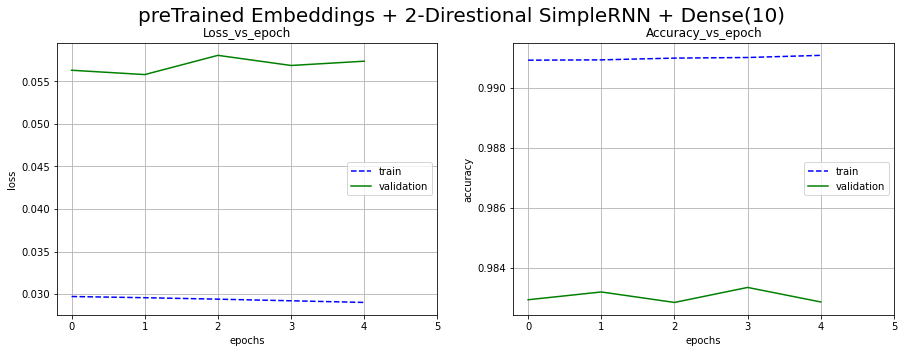

In [269]:
make_plots(model_4,name='preTrained Embeddings + 2-Direstional SimpleRNN + Dense(10)',save=True)

In [271]:
acc = calc_test_accuracy(model_4)
print("Model(preTrained Embeddings + 2-Direstional SimpleRNN + Dense(10)) accuracy: %.5f"%acc)

assert acc>0.94

Model(preTrained Embeddings + 2-Direstional SimpleRNN + Dense(10)) accuracy: 0.98215


Результат модели БЕЗ обученных embedding-ов:

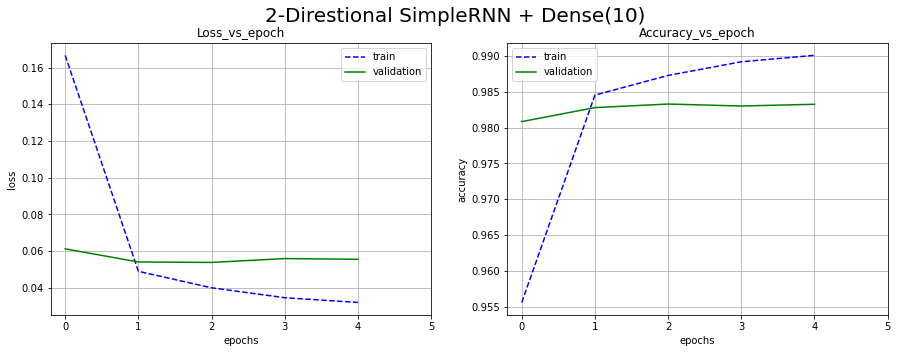

In [456]:
make_plots(model_2,name='2-Direstional SimpleRNN + Dense(10)',save=True)

#### Вывод: 
Результат, по сравнению с моделью БЕЗ обученных векторов слов:
- БЕЗ обученных векторов слов accuracy = 0.98200
- C обученных векторов слов accuracy = 0.98215 (текущая модель)

**Загружать вектора слов нет необходимости - модель на 2 эпохе сама подобрала правильные веса.** 
(скорее всего, имеет смысл, если слов очень много)

### Model with word dropout

In [432]:
# word dropout function
def make_dropout(matrix_words,matrix_tags, probability = 0.5 ,fill_value = None):
    if fill_value is None: fill_value = tag_to_id['#UNK#'] # tag_to_id['#UNK#'] =1

    #matrix,*_ = make_matrix_for_RNN(data[1:3])
    mask = np.random.choice(2,size=matrix_words.shape,p=[probability,1-probability])
    mask = mask & matrix_words   # mask &= matrix
    mask = mask != 0             # mask != 0
    
    matrix_words = np.choose(mask,[matrix_words,np.full(shape = matrix_words.shape ,fill_value = fill_value)])
    matrix_tags = np.choose(mask,[matrix_tags,np.full(shape = matrix_tags.shape ,fill_value = fill_value)])
    
    return matrix_words,matrix_tags

In [356]:
X,y = make_matrix_for_RNN(data[1:3])

X_1,y_1 =make_dropout(X,y)

assert np.sum(X_1 == 1)> np.sum(X == 1)
assert np.sum(y_1 == 1)> np.sum(y == 1)
assert np.sum(X_1 == 1)== np.sum(y_1 == 1)
print('Done')
del X_1,y_1

Done


In [433]:
pad_id,unknown_id = map(word_to_id.get, ['#EOS#','#UNK#'] )

def make_matrix_for_RNN(sequences,max_len=None,dropout=None):
    #sequences = data[:3]
    # узнаем макс длину матрицы
    if max_len is None:
        max_len = min(max(map(len, sequences)), np.inf) 
        
    # создадим матрицу размера No.sequences, max_len, fill PAD
    matrix_words = np.full(shape=(len(sequences),max_len ),fill_value=pad_id, dtype=int)
    matrix_tags = np.full(shape=(len(sequences),max_len ),fill_value=pad_id, dtype=int)
    
    # пробежимся по матрице и каждый ряд заполняем id слова или (если такое слово отсутствует ставим UNK_id)
    for i,line in enumerate(sequences):
        word,tag = zip(*line)
        a = [word_to_id.get(i,unknown_id) for i in word ]
        b = [tag_to_id.get(i,unknown_id) for i in tag ]
        b = [b[i] if a[i]!=1 else 1 for i in (range(len(a))) ]
        
        matrix_words[i,:len(a)] = a
        matrix_tags[i,:len(b)] = b
    # делаем дропаут
    if dropout is not None:
           matrix_words,matrix_tags = make_dropout(matrix_words,matrix_tags,probability=dropout)
    
    return matrix_words,matrix_tags

In [366]:
#Define a model that utilizes dropout
model_5 = keras.models.Sequential()

#input
model_5.add(keras.layers.Input(shape=[None],batch_size=12,dtype=np.int16 ))

#make Embedding
words_vocabulary_length = len(word_to_id)
model_5.add(keras.layers.Embedding(input_dim=words_vocabulary_length, 
          output_dim=100, input_length=12 ))

#make two-directional RNN
rnn_hidden_state = len(tag_to_id)
RNN_layer = keras.layers.SimpleRNN(units = rnn_hidden_state,
          activation = 'tanh',
          return_sequences=True,
          stateful=True) 
model_5.add( keras.layers.Bidirectional(RNN_layer) )
            
#make TimeDistibuted Dense
Dense_layer = keras.layers.Dense(len(tag_to_id),activation=keras.activations.softmax)
model_5.add( keras.layers.TimeDistributed(Dense_layer))        
            

In [367]:
model_5.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (12, None, 100)           1000200   
_________________________________________________________________
bidirectional_5 (Bidirection (12, None, 28)            3220      
_________________________________________________________________
time_distributed_2 (TimeDist (12, None, 14)            406       
Total params: 1,003,826
Trainable params: 1,003,826
Non-trainable params: 0
_________________________________________________________________


In [368]:
model_5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-3, epsilon=1e-08), 
              loss=keras.losses.categorical_crossentropy,
              metrics=keras.metrics.categorical_accuracy)

In [369]:
callbacks = [keras.callbacks.ModelCheckpoint(
        filepath='./saved_models/model_5.{epoch:03d}-loss_{val_loss:.2f}.h5',
        save_best_only=True,
        save_weights_only=True,
        monitor='val_loss',
        mode='min'),
        
        keras.callbacks.TensorBoard(
        log_dir ='../TensorBoard_logs/' ,
        histogram_freq = 1,
        write_graph = False,
        write_images = False,
        write_steps_per_second = False,
        update_freq = 'epoch',
        profile_batch = 2,
        embeddings_freq = 1
        )]

In [371]:
batch_size = 12
epochs = 5
step_per_epoch = (len(X_train)+1) // (batch_size+1)
validation_steps = (len(X_val)+1) // (batch_size+1)

model_5.fit(iterate_minibatches(X_train, batch_size = batch_size ,shuffle=True,dropout=0.5),
         epochs = epochs, steps_per_epoch = step_per_epoch,
         callbacks = callbacks,
         validation_data = iterate_minibatches(X_val, batch_size = batch_size ,shuffle=True),
         validation_steps = validation_steps, verbose=1 )

Epoch 1/5
2811/2811 [==============================] - 86s 30ms/step - loss: 0.0582 - categorical_accuracy: 0.9837 - val_loss: 0.0348 - val_categorical_accuracy: 0.9892
Epoch 2/5
2811/2811 [==============================] - 83s 30ms/step - loss: 0.0228 - categorical_accuracy: 0.9924 - val_loss: 0.0314 - val_categorical_accuracy: 0.9901
Epoch 3/5
2811/2811 [==============================] - 84s 30ms/step - loss: 0.0203 - categorical_accuracy: 0.9931 - val_loss: 0.0292 - val_categorical_accuracy: 0.9909
Epoch 4/5
2811/2811 [==============================] - 84s 30ms/step - loss: 0.0189 - categorical_accuracy: 0.9935 - val_loss: 0.0292 - val_categorical_accuracy: 0.9909
Epoch 5/5
2811/2811 [==============================] - 84s 30ms/step - loss: 0.0187 - categorical_accuracy: 0.9936 - val_loss: 0.0287 - val_categorical_accuracy: 0.9910


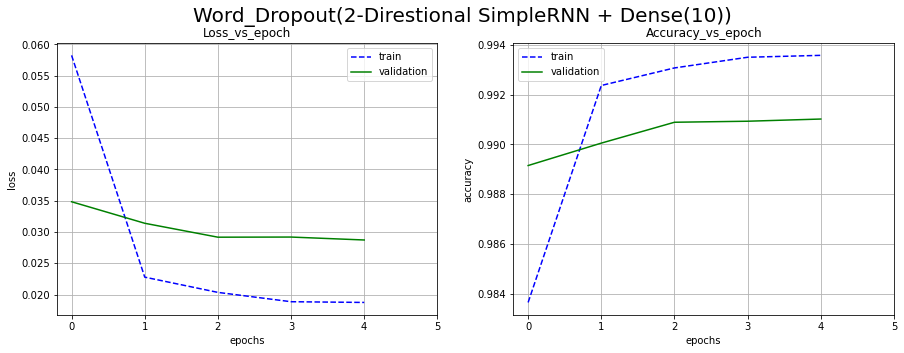

In [372]:
make_plots(model_5,name='Word_Dropout(2-Direstional SimpleRNN + Dense(10))',save=True)

In [374]:
acc = calc_test_accuracy(model_5)
print("Word_Dropout(2-Direstional SimpleRNN + Dense(10)) accuracy: %.5f"%acc)

assert acc>0.94

Word_Dropout(2-Direstional SimpleRNN + Dense(10)) accuracy: 0.99087


Результат модели БЕЗ dropout:

#### Вывод: 
Топ результатов:  
- БЕЗ dropout accuracy = 0.98200
- C dropout accuracy = 0.99087 (текущая модель)

**Добавлять dropout имеет значение**

### Same with LSTM layer
2-Direstional LSTM + Dense(10)

In [375]:
#Define a model that utilizes LSTM
model_6 = keras.models.Sequential()

#input
model_6.add(keras.layers.Input(shape=[None],batch_size=12,dtype=np.int16 ))

#make Embedding
words_vocabulary_length = len(word_to_id)
model_6.add(keras.layers.Embedding(input_dim=words_vocabulary_length, 
          output_dim=100, input_length=12 ))

#make two-directional RNN
rnn_hidden_state = len(tag_to_id)
LSTM_layer = keras.layers.LSTM(units = rnn_hidden_state,
          activation = 'tanh',
          return_sequences=True,
          stateful=True) 
model_6.add( keras.layers.Bidirectional(LSTM_layer) )
            
#make TimeDistibuted Dense
Dense_layer = keras.layers.Dense(len(tag_to_id),activation=keras.activations.softmax)
model_6.add( keras.layers.TimeDistributed(Dense_layer))        
            

In [376]:
model_6.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (12, None, 100)           1000200   
_________________________________________________________________
bidirectional_6 (Bidirection (12, None, 28)            12880     
_________________________________________________________________
time_distributed_3 (TimeDist (12, None, 14)            406       
Total params: 1,013,486
Trainable params: 1,013,486
Non-trainable params: 0
_________________________________________________________________


In [377]:
model_6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-3, epsilon=1e-08), 
              loss=keras.losses.categorical_crossentropy,
              metrics=keras.metrics.categorical_accuracy)

In [378]:
callbacks = [keras.callbacks.ModelCheckpoint(
        filepath='./saved_models/model_6.{epoch:03d}-loss_{val_loss:.2f}.h5',
        save_best_only=True,
        save_weights_only=True,
        monitor='val_loss',
        mode='min'),
        
        keras.callbacks.TensorBoard(
        log_dir ='../TensorBoard_logs/' ,
        histogram_freq = 1,
        write_graph = False,
        write_images = False,
        write_steps_per_second = False,
        update_freq = 'epoch',
        profile_batch = 2,
        embeddings_freq = 1
        )]

In [379]:
batch_size = 12
epochs = 5
step_per_epoch = (len(X_train)+1) // (batch_size+1)
validation_steps = (len(X_val)+1) // (batch_size+1)

model_6.fit(iterate_minibatches(X_train, batch_size = batch_size ,shuffle=True),
         epochs = epochs, steps_per_epoch = step_per_epoch,
         callbacks = callbacks,
         validation_data = iterate_minibatches(X_val, batch_size = batch_size ,shuffle=True),
         validation_steps = validation_steps, verbose=1 )

Epoch 1/5
2811/2811 [==============================] - 106s 36ms/step - loss: 0.0761 - categorical_accuracy: 0.9782 - val_loss: 0.0286 - val_categorical_accuracy: 0.9915
Epoch 2/5
2811/2811 [==============================] - 102s 36ms/step - loss: 0.0195 - categorical_accuracy: 0.9939 - val_loss: 0.0252 - val_categorical_accuracy: 0.9926
Epoch 3/5
2811/2811 [==============================] - 107s 38ms/step - loss: 0.0159 - categorical_accuracy: 0.9951 - val_loss: 0.0255 - val_categorical_accuracy: 0.9924
Epoch 4/5
2811/2811 [==============================] - 115s 41ms/step - loss: 0.0137 - categorical_accuracy: 0.9957 - val_loss: 0.0255 - val_categorical_accuracy: 0.9924
Epoch 5/5
2811/2811 [==============================] - 104s 37ms/step - loss: 0.0121 - categorical_accuracy: 0.9962 - val_loss: 0.0276 - val_categorical_accuracy: 0.9923


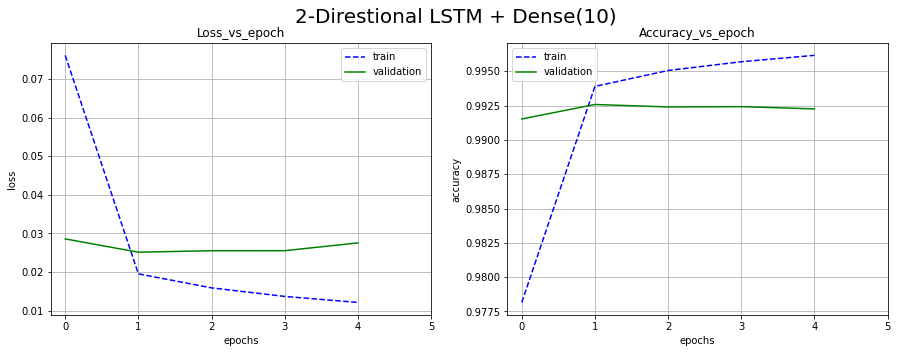

In [380]:
make_plots(model_6,name='2-Direstional LSTM + Dense(10)',save=True)

In [383]:
acc = calc_test_accuracy(model_6)
print("2-Direstional LSTM + Dense(10) accuracy: %.5f"%acc)

assert acc>0.94

2-Direstional LSTM + Dense(10) accuracy: 0.99187


#### Вывод: 
Топ результатов: 
- 2-Direstional RNN + Dense. accuracy = 0.98200
- 2-Direstional RNN + dropout. accuracy = 0.99087
- 2-Direstional __LSTM__ . accuracy = __0.99187__ (текущая модель)

**Добавлять LSTM имеет значение**

### LSTM layer + dropout 
2-Direstional LSTM (training dropout) + Dense(10)

In [389]:
#Define a model that utilizes LSTM
#input
input_layer = keras.layers.Input(shape=[None],batch_size=12,dtype=np.int16 )

#make Embedding
words_vocabulary_length = len(word_to_id)
embedding_layer = keras.layers.Embedding(input_dim=words_vocabulary_length, 
                                        output_dim=100,
                                        input_length=12)(input_layer)
#make two-directional LSTM
rnn_hidden_state = len(tag_to_id)
LSTM_layer = keras.layers.LSTM(units = rnn_hidden_state,
                                  activation = 'tanh',
                                  dropout = .5,
                                  return_sequences=True,
                                  stateful=True)
two_directional_LSTM_layer = keras.layers.Bidirectional(LSTM_layer)(inputs=(embedding_layer),training = True)

#make TimeDistibuted Dense
Dense_layer = keras.layers.Dense(len(tag_to_id),activation=keras.activations.softmax)
Time_Distibuted_layer = keras.layers.TimeDistributed(Dense_layer)(two_directional_LSTM_layer)


model_7 = keras.models.Model(inputs = input_layer, outputs = Time_Distibuted_layer  )

In [390]:
model_7.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(12, None)]              0         
_________________________________________________________________
embedding_11 (Embedding)     (12, None, 100)           1000200   
_________________________________________________________________
bidirectional_8 (Bidirection (12, None, 28)            12880     
_________________________________________________________________
time_distributed_5 (TimeDist (12, None, 14)            406       
Total params: 1,013,486
Trainable params: 1,013,486
Non-trainable params: 0
_________________________________________________________________


In [393]:
model_7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-3, epsilon=1e-08), 
              loss=keras.losses.categorical_crossentropy,
              metrics=keras.metrics.categorical_accuracy)

In [394]:
callbacks = [keras.callbacks.ModelCheckpoint(
        filepath='./saved_models/model_7.{epoch:03d}-loss_{val_loss:.2f}.h5',
        save_best_only=True,
        save_weights_only=True,
        monitor='val_loss',
        mode='min'),
        
        keras.callbacks.TensorBoard(
        log_dir ='../TensorBoard_logs/' ,
        histogram_freq = 1,
        write_graph = False,
        write_images = False,
        write_steps_per_second = False,
        update_freq = 'epoch',
        profile_batch = 2,
        embeddings_freq = 1
        )]

In [395]:
batch_size = 12
epochs = 5
step_per_epoch = (len(X_train)+1) // (batch_size+1)
validation_steps = (len(X_val)+1) // (batch_size+1)

model_7.fit(iterate_minibatches(X_train, batch_size = batch_size ,shuffle=True),
         epochs = epochs, steps_per_epoch = step_per_epoch,
         callbacks = callbacks,
         validation_data = iterate_minibatches(X_val, batch_size = batch_size ,shuffle=True),
         validation_steps = validation_steps, verbose=1 )

Epoch 1/5
2811/2811 [==============================] - 110s 38ms/step - loss: 0.0853 - categorical_accuracy: 0.9762 - val_loss: 0.0335 - val_categorical_accuracy: 0.9900
Epoch 2/5
2811/2811 [==============================] - 110s 39ms/step - loss: 0.0264 - categorical_accuracy: 0.9918 - val_loss: 0.0299 - val_categorical_accuracy: 0.9907
Epoch 3/5
2811/2811 [==============================] - 108s 39ms/step - loss: 0.0243 - categorical_accuracy: 0.9923 - val_loss: 0.0305 - val_categorical_accuracy: 0.9907
Epoch 4/5
2811/2811 [==============================] - 109s 39ms/step - loss: 0.0227 - categorical_accuracy: 0.9928 - val_loss: 0.0296 - val_categorical_accuracy: 0.9907
Epoch 5/5
2811/2811 [==============================] - 112s 40ms/step - loss: 0.0222 - categorical_accuracy: 0.9930 - val_loss: 0.0294 - val_categorical_accuracy: 0.9912


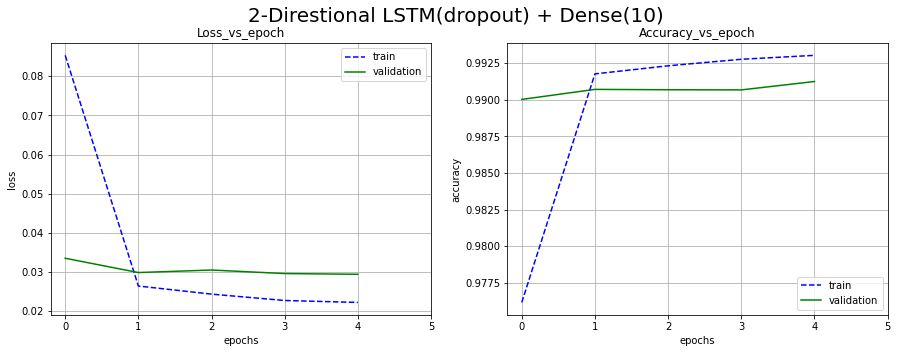

In [396]:
make_plots(model_7,name='2-Direstional LSTM(dropout) + Dense(10)',save=True)

In [397]:
acc = calc_test_accuracy(model_7)
print("Word_Dropout(2-Directional LSTM(dropout) + Dense(10)) accuracy: %.5f"%acc)

assert acc>0.94

Word_Dropout(2-Directional LSTM(dropout) + Dense(10)) accuracy: 0.99074


In [398]:
!telegram-send "Job's_Done"

#### Вывод: 
Топ результатов:  
- 2-Direstional RNN + __word_dropout__. accuracy = 0.99087
- 2-Direstional __LSTM__. accuracy = __0.99187__
- 2-Direstional LSTM + __inuts_dropout__. accuracy = 0.99074 (текущая модель)

**Добавлять inuts_dropout в LSTM НЕ имеет значение**  
зато добавить word_dropout имеет значение

### LSTM layer + Conv1D(64)  + Dense(10) 

In [484]:
#Define a model that utilizes LSTM layer + Conv1D(64)  + Dense(10) 
model_8 = keras.models.Sequential()

#input
model_8.add(keras.layers.Input(shape=[None],batch_size=12,dtype=np.int16 ))

#make Embedding
words_vocabulary_length = len(word_to_id)
model_8.add(keras.layers.Embedding(input_dim=words_vocabulary_length, 
          output_dim=100, input_length=12 ))

#make two-directional RNN
rnn_hidden_state = len(tag_to_id)
LSTM_layer = keras.layers.LSTM(units = rnn_hidden_state,
          activation = 'tanh',
          return_sequences=True,
          stateful=True) 
model_8.add( keras.layers.Bidirectional(LSTM_layer) )

#make Conv1D(64)
model_8.add( keras.layers.Convolution1D(filters=64, kernel_size=3,padding='same', 
                            activation = keras.activations.relu ) )
            
#make TimeDistibuted Dense
Dense_layer = keras.layers.Dense(len(tag_to_id),activation=keras.activations.softmax)
model_8.add( keras.layers.TimeDistributed(Dense_layer))        
            

In [464]:
model_8.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(12, None)]              0         
_________________________________________________________________
embedding_23 (Embedding)     (12, None, 100)           1000200   
_________________________________________________________________
lstm_17 (LSTM)               (12, None, 14)            6440      
_________________________________________________________________
conv1d_11 (Conv1D)           (12, None, 64)            2752      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (12, None, 64)            0         
_________________________________________________________________
time_distributed_17 (TimeDis (12, None, 14)            910       
Total params: 1,010,302
Trainable params: 1,010,302
Non-trainable params: 0
________________________________________________

In [485]:
model_8.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-3, epsilon=1e-08), 
              loss=keras.losses.categorical_crossentropy,
              metrics=keras.metrics.categorical_accuracy)

In [459]:
callbacks = [keras.callbacks.ModelCheckpoint(
        filepath='./saved_models/model_8.{epoch:03d}-loss_{val_loss:.2f}.h5',
        save_best_only=True,
        save_weights_only=True,
        monitor='val_loss',
        mode='min'),
        
        keras.callbacks.TensorBoard(
        log_dir ='../TensorBoard_logs/' ,
        histogram_freq = 1,
        write_graph = False,
        write_images = False,
        write_steps_per_second = False,
        update_freq = 'epoch',
        profile_batch = 2,
        embeddings_freq = 1
        )]

In [486]:
batch_size = 12
epochs = 5
step_per_epoch = (len(X_train)+1) // (batch_size+1)
validation_steps = (len(X_val)+1) // (batch_size+1)

model_8.fit(iterate_minibatches(X_train, batch_size = batch_size ,shuffle=True),
         epochs = epochs, steps_per_epoch = step_per_epoch,
         callbacks = callbacks,
         validation_data = iterate_minibatches(X_val, batch_size = batch_size ,shuffle=True),
         validation_steps = validation_steps, verbose=1 )

Epoch 1/5
2811/2811 [==============================] - 109s 37ms/step - loss: 0.0742 - categorical_accuracy: 0.9783 - val_loss: 0.0283 - val_categorical_accuracy: 0.9914
Epoch 2/5
2811/2811 [==============================] - 114s 41ms/step - loss: 0.0192 - categorical_accuracy: 0.9941 - val_loss: 0.0307 - val_categorical_accuracy: 0.9916
Epoch 3/5
2811/2811 [==============================] - 110s 39ms/step - loss: 0.0152 - categorical_accuracy: 0.9953 - val_loss: 0.0267 - val_categorical_accuracy: 0.9924
Epoch 4/5
2811/2811 [==============================] - 110s 39ms/step - loss: 0.0131 - categorical_accuracy: 0.9960 - val_loss: 0.0312 - val_categorical_accuracy: 0.9917
Epoch 5/5
2811/2811 [==============================] - 120s 43ms/step - loss: 0.0114 - categorical_accuracy: 0.9965 - val_loss: 0.0260 - val_categorical_accuracy: 0.9930


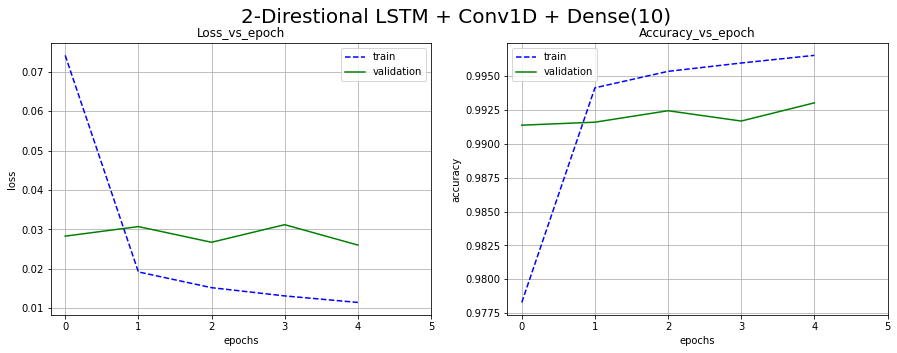

In [487]:
make_plots(model_8,name='2-Direstional LSTM + Conv1D + Dense(10)',save=True)

In [488]:
acc = calc_test_accuracy(model_8)
print("Word_Dropout(2-Directional LSTM(dropout) + Dense(10)) accuracy: %.5f"%acc)

assert acc>0.94

Word_Dropout(2-Directional LSTM(dropout) + Dense(10)) accuracy: 0.99255


#### Вывод: 
Топ Результатов:
- 2-Direstional RNN + Dense. accuracy = 0.98200
- 2-Direstional RNN + word_dropout. accuracy = 0.99087
- 2-Direstional LSTM . accuracy = 0.99187
- 2-Direstional LSTM + Conv1D . accuracy = __0.99255__ (текущая модель)

**Добавлять Conv1D имеет значение**

### More efficient batching

In [534]:
# чтобы длины предложений в батче были одинаковыми
def get_larger_key(key,dict_keys_list ):
    for i in dict_keys_list:
        if i>key:
            return i
         
    return dict_keys_list[50]


def make_same_length(source):
    a = {}
    for index_i in range(len(source)):
        length = len(source[index_i])
        if length not in a.keys():
            a[length] = []
        a[length].append(index_i)

    a_length = list(a.keys())

    length = np.random.choice(a_length ) 
    batch_indexes = []
    batch_indexes += a[length]

    while len(batch_indexes) < 12:
        batch_indexes += a[get_larger_key(length,a_length)]

    return batch_indexes[:12]

In [535]:
from keras.utils.np_utils import to_categorical

def iterate_minibatches(source,batch_size = 12,shuffle=True,same_length=False, **kwargs):
    while True:
        data_indexes = np.arange(len(source))
        if shuffle:
            #shuffle
            data_indexes_shuffled = np.random.permutation(data_indexes)
            batch_indexes = data_indexes_shuffled[:batch_size]
        else:
            # NO shuffle
            batch_indexes = data_indexes[-batch_size:] #no shuffle is useless

            
        # чтобы длины предложений в батче были одинаковыми
        if same_length:
            batch_indexes = make_same_length(source=source)
            

        #generating X and y 
        batch,target = make_matrix_for_RNN(source[batch_indexes], **kwargs)

        target = to_categorical(target, len(all_tags) ).reshape(target.shape+(-1,))

        yield batch,target

In [537]:
batch_size = 12
epochs = 5
step_per_epoch = (len(X_train)+1) // (batch_size+1)
validation_steps = (len(X_val)+1) // (batch_size+1)

model_8.fit(iterate_minibatches(X_train, batch_size = batch_size ,shuffle=False, same_length=True),
         epochs = epochs, steps_per_epoch = step_per_epoch,
         callbacks = callbacks,
         validation_data = iterate_minibatches(X_val, batch_size = batch_size ,shuffle=True),
         validation_steps = validation_steps, verbose=1 )

Epoch 1/5
2811/2811 [==============================] - 174s 62ms/step - loss: 0.0039 - categorical_accuracy: 0.9996 - val_loss: 0.0513 - val_categorical_accuracy: 0.9916
Epoch 2/5
2811/2811 [==============================] - 179s 64ms/step - loss: 0.0029 - categorical_accuracy: 0.9997 - val_loss: 0.0626 - val_categorical_accuracy: 0.9904
Epoch 3/5
2811/2811 [==============================] - 178s 63ms/step - loss: 0.0029 - categorical_accuracy: 0.9998 - val_loss: 0.0820 - val_categorical_accuracy: 0.9893
Epoch 4/5
2811/2811 [==============================] - 177s 63ms/step - loss: 0.0020 - categorical_accuracy: 0.9999 - val_loss: 0.0778 - val_categorical_accuracy: 0.9900
Epoch 5/5
2811/2811 [==============================] - 174s 62ms/step - loss: 0.0041 - categorical_accuracy: 0.9996 - val_loss: 0.0842 - val_categorical_accuracy: 0.9887


In [568]:
@tf.function  
def predict(model,array):
    return model(array)

In [566]:
def calc_test_accuracy(model):
    acc =0
    batches = len(test_data)//12
    
    for i in range(0,batches,1):
        X,y = make_matrix_for_RNN(test_data[i*12:i*12+12]) 
        y_predicted = np.argmax(predict(model,X),axis=-1)
        #y=np.argmax(y,axis=-1)
        acc += accuracy_score(np.ravel(y),np.ravel(y_predicted))
    
    return acc/ batches

In [567]:
acc = calc_test_accuracy(model_8)
print("Same batch length model(2-Directional RNN +Dense(10). accuracy: %.5f"%acc)

assert acc>0.94

Exception ignored in: <function ScopedTFFunction.__del__ at 0x0000000028A05CA0>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 110, in __del__
    self.deleter(self.func)
KeyboardInterrupt: 


Same batch length model(2-Directional RNN +Dense(10). accuracy: 0.98834


#### Вывод: 
Топ Результатов:
- 2-Direstional RNN + Dense. accuracy = 0.98200
- 2-Direstional RNN + word_dropout. accuracy = 0.99087
- 2-Direstional LSTM . accuracy = 0.99187
- 2-Direstional LSTM + Conv1D . accuracy = __0.99255__
- 2-Direstional LSTM + Conv1D + Batch same length. accuracy = 0.98834 (текущая модель)

**Добавлять Batch same length НЕ имеет значение**

### Соберем все  единую модель:
+ 2-Direstional LSTM + Conv1D
+ word_dropout

In [570]:
#Define a model that utilizes LSTM layer + Conv1D(64)  + Dense(10) 
model_9 = keras.models.Sequential()

#input
model_9.add(keras.layers.Input(shape=[None],batch_size=12,dtype=np.int16 ))

#make Embedding
words_vocabulary_length = len(word_to_id)
model_9.add(keras.layers.Embedding(input_dim=words_vocabulary_length, 
          output_dim=100, input_length=12 ))

#make two-directional RNN
rnn_hidden_state = len(tag_to_id)
LSTM_layer = keras.layers.LSTM(units = rnn_hidden_state,
          activation = 'tanh',
          return_sequences=True,
          stateful=True) 
model_9.add( keras.layers.Bidirectional(LSTM_layer) )

#make Conv1D(128)
model_9.add( keras.layers.Convolution1D(filters=128, kernel_size=3,padding='same', 
                            activation = keras.activations.relu ) )
            
#make TimeDistibuted Dense
Dense_layer = keras.layers.Dense(len(tag_to_id),activation=keras.activations.softmax)
model_9.add( keras.layers.TimeDistributed(Dense_layer))        
            

In [571]:
model_9.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (12, None, 100)           1000200   
_________________________________________________________________
bidirectional_13 (Bidirectio (12, None, 28)            12880     
_________________________________________________________________
conv1d_17 (Conv1D)           (12, None, 128)           10880     
_________________________________________________________________
time_distributed_24 (TimeDis (12, None, 14)            1806      
Total params: 1,025,766
Trainable params: 1,025,766
Non-trainable params: 0
_________________________________________________________________


In [572]:
model_9.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-3, epsilon=1e-08), 
              loss=keras.losses.categorical_crossentropy,
              metrics=keras.metrics.categorical_accuracy)

In [573]:
callbacks = [keras.callbacks.ModelCheckpoint(
        filepath='./saved_models/model_9.{epoch:03d}-loss_{val_loss:.2f}.h5',
        save_best_only=True,
        save_weights_only=True,
        monitor='val_loss',
        mode='min'),
        
        keras.callbacks.TensorBoard(
        log_dir ='../TensorBoard_logs/model_9' ,
        histogram_freq = 1,
        write_graph = False,
        write_images = False,
        write_steps_per_second = False,
        update_freq = 'epoch',
        profile_batch = 2,
        embeddings_freq = 1
        )]

In [575]:
batch_size = 12
epochs = 5
step_per_epoch = (len(X_train)+1) // (batch_size+1)
validation_steps = (len(X_val)+1) // (batch_size+1)

model_9.fit(iterate_minibatches(X_train, batch_size = batch_size ,shuffle=True,dropout=0.5),
         epochs = epochs, steps_per_epoch = step_per_epoch,
         callbacks = callbacks,
         validation_data = iterate_minibatches(X_val, batch_size = batch_size ,shuffle=True),
         validation_steps = validation_steps, verbose=1 )

Epoch 1/5
2811/2811 [==============================] - 120s 42ms/step - loss: 0.0647 - categorical_accuracy: 0.9809 - val_loss: 0.0320 - val_categorical_accuracy: 0.9904
Epoch 2/5
2811/2811 [==============================] - 113s 40ms/step - loss: 0.0209 - categorical_accuracy: 0.9932 - val_loss: 0.0283 - val_categorical_accuracy: 0.9916
Epoch 3/5
2811/2811 [==============================] - 113s 40ms/step - loss: 0.0186 - categorical_accuracy: 0.9940 - val_loss: 0.0284 - val_categorical_accuracy: 0.9915
Epoch 4/5
2811/2811 [==============================] - 114s 41ms/step - loss: 0.0167 - categorical_accuracy: 0.9945 - val_loss: 0.0288 - val_categorical_accuracy: 0.9916
Epoch 5/5
2811/2811 [==============================] - 114s 41ms/step - loss: 0.0152 - categorical_accuracy: 0.9949 - val_loss: 0.0289 - val_categorical_accuracy: 0.9918


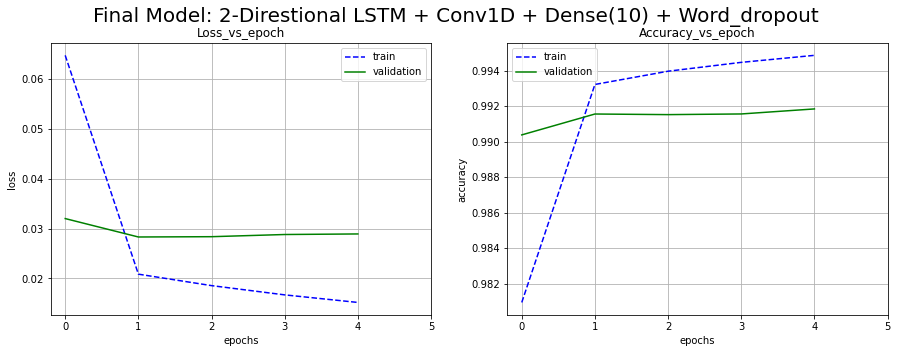

In [576]:
make_plots(model_9,name='Final Model: 2-Direstional LSTM + Conv1D + Dense(10) + Word_dropout',save=True)

In [577]:
acc = calc_test_accuracy(model_9)
print("Word_Dropout(2-Directional LSTM(dropout) + Conv1D + Dense(10)) accuracy: %.5f"%acc)

assert acc>0.94

Word_Dropout(2-Directional LSTM(dropout) + Conv1D + Dense(10)) accuracy: 0.99176


#### Вывод: 
Топ Результатов:  
- 2-Direstional RNN + CRF. accuracy = 0.98200
- 2-Direstional RNN + Dense. accuracy = 0.98200
- 2-Direstional RNN + Dense + word_dropout. accuracy = 0.99087
- 2-Direstional LSTM + Conv1D . accuracy = __0.99255__
- 2-Direstional LSTM + Conv1D + word_dropout. accuracy = 0.99176

**Самая лучшая модель 2-Direstional LSTM + Conv1D(64) + Dense(10)**

Было проверено:
- новый слой CRF + negative_log_likelihood loss function ( которого нет ни в keras ни в tensor flow)
- word_dropout, 
- element_dropout,
- 2-Direstional SimpleRNN,
- подбор количества фильтров для слоя Conv1D,
- batch normalization, 
- pre-trained embedding, 
- batch length optimization
